<a href="https://colab.research.google.com/github/karan2261/Pytorch-Capstone-Project/blob/main/Pytorch_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset from Google Drive
dataset = ImageFolder('/content/drive/My Drive/Weather Image Recognition Dataset', transform=transform)

In [ ]:
# Get the number of classes
num_classes = len(dataset.classes)

# Print information about the dataset
print("Number of classes:", num_classes)
print("Class names:", dataset.classes)
print("Total number of images:", len(dataset))

# First image in the dataset
image, label = dataset[0]
print("Image shape:", image.shape)

Number of classes: 11
Class names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Total number of images: 6862
Image shape: torch.Size([3, 224, 224])


In [ ]:
# Using only 30% of the dataset
sample_size = 0.3
sample_dataset, _ = random_split(dataset, [int(sample_size * len(dataset)), len(dataset) - int(sample_size * len(dataset))])

In [ ]:
# Splitting the dataset into training, validation, and test sets
train_size = int(0.7 * len(sample_dataset))
val_size = int(0.15 * len(sample_dataset))
test_size = len(sample_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(sample_dataset, [train_size, val_size, test_size])

# Creating a DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
# Augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply augmentation to the training dataset
augmented_dataset = ImageFolder(root='/content/drive/My Drive/Weather Image Recognition Dataset', transform=train_transform)
augmented_sample_dataset, _ = random_split(augmented_dataset, [int(sample_size * len(augmented_dataset)), len(augmented_dataset) - int(sample_size * len(augmented_dataset))])
train_data_augmented, _ = random_split(augmented_sample_dataset, [train_size, len(augmented_sample_dataset) - train_size])
train_loader_augmented = DataLoader(train_data_augmented, batch_size=32, shuffle=True)

In [ ]:
# Define a CNN model using a pre-trained ResNet
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initializing the model
num_classes = len(dataset.classes)
model = CNNModel(num_classes=num_classes)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.1MB/s]


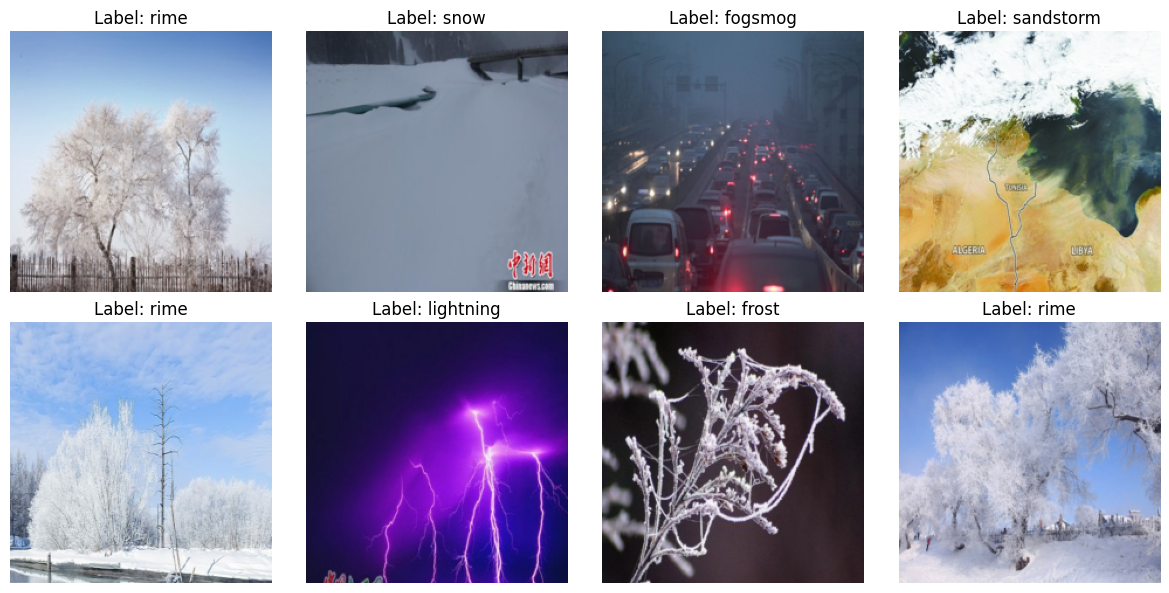

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get some images from the training loader
images, labels = next(iter(train_loader))

# Display the images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Un-normalize the image
    image = images[i].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(f"Label: {dataset.classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Parameters for early stopping
patience = 3
delta = 0.001
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop with steps
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Step [{i+1}/{len(train_loader_augmented)}], Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping
    if val_loss < best_val_loss - delta:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

Epoch 1/10
Step [10/45], Loss: 1.5151
Step [20/45], Loss: 1.0705
Step [30/45], Loss: 1.4231
Step [40/45], Loss: 1.6881
Validation Loss: 1.7080, Validation Accuracy: 61.36%
Epoch 2/10
Step [10/45], Loss: 0.8870
Step [20/45], Loss: 0.6569
Step [30/45], Loss: 0.8580
Step [40/45], Loss: 0.9111
Validation Loss: 0.9658, Validation Accuracy: 70.13%
Epoch 3/10
Step [10/45], Loss: 0.4988
Step [20/45], Loss: 0.5548
Step [30/45], Loss: 0.8146
Step [40/45], Loss: 0.8157
Validation Loss: 0.9078, Validation Accuracy: 71.75%
Epoch 4/10
Step [10/45], Loss: 0.5914
Step [20/45], Loss: 0.4287
Step [30/45], Loss: 0.8196
Step [40/45], Loss: 0.7475
Validation Loss: 0.8826, Validation Accuracy: 70.45%
Epoch 5/10
Step [10/45], Loss: 1.0051
Step [20/45], Loss: 0.8740
Step [30/45], Loss: 0.5956
Step [40/45], Loss: 0.2326
Validation Loss: 0.6954, Validation Accuracy: 79.22%
Epoch 6/10
Step [10/45], Loss: 0.4629
Step [20/45], Loss: 0.4084
Step [30/45], Loss: 0.3998
Step [40/45], Loss: 0.4056
Validation Loss: 0.74

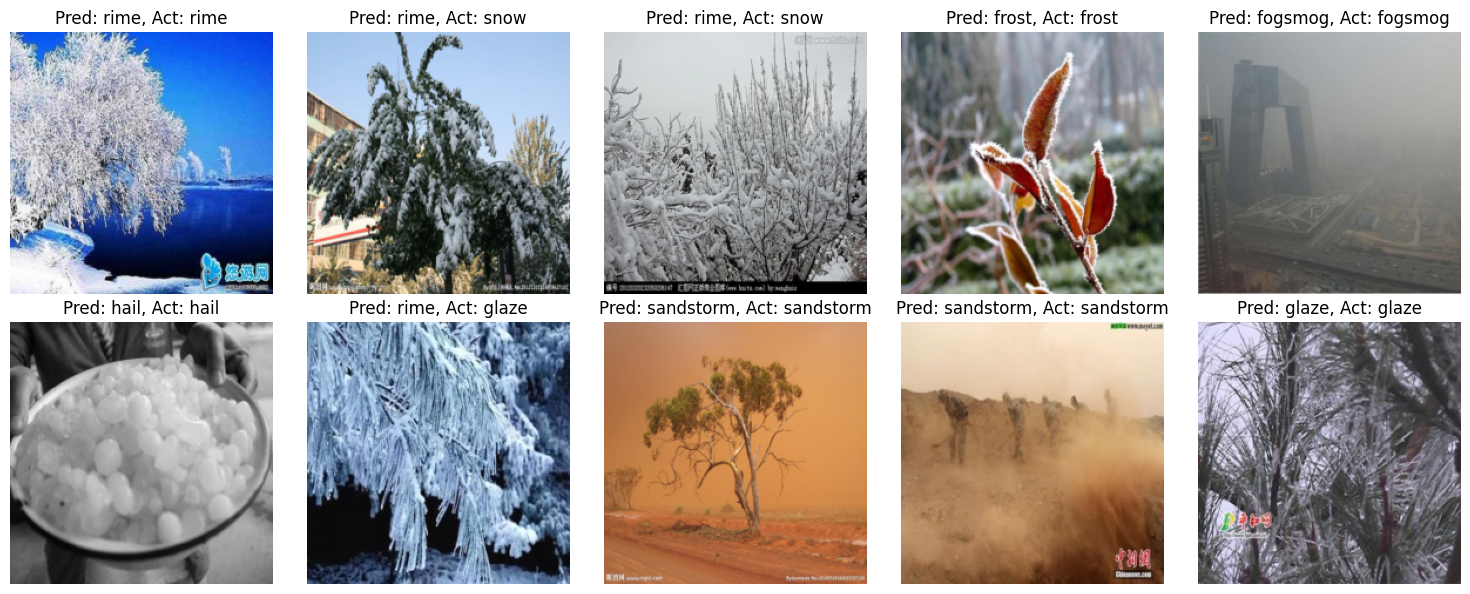

In [ ]:
# Function to plot predictions
def plot_predictions(model, test_loader, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    images, labels = next(iter(test_loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Display the images
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        image = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        ax.imshow(image)
        ax.set_title(f"Pred: {dataset.classes[preds[i]]}, Act: {dataset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Perform testing and plot results
plot_predictions(model, test_loader, num_images=10)

In [ ]:
# # Hyperparameter tuning
# # List of hyperparameters to try
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64]

# Record of hyperparameters and their performance
results = []

# Define the function to train and evaluate the model with early stopping
def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs, patience=3, delta=0.001):
    model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break

    return val_accuracy

# Loop through hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate: {lr}, batch size: {batch_size}")

        # Create DataLoader with the current batch size
        train_loader = DataLoader(train_data_augmented, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size)

        # Initialize the model, criterion, and optimizer
        model = CNNModel(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train and evaluate the model
        val_accuracy = train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10)

        # Record the results
        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'validation_accuracy': val_accuracy
        })

# Print the results
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Batch Size: {result['batch_size']}, Validation Accuracy: {result['validation_accuracy']:.2f}%")

Training with learning rate: 0.001, batch size: 16
Epoch 1/10
Validation Loss: 1.7225, Validation Accuracy: 40.26%
Epoch 2/10
Validation Loss: 1.2838, Validation Accuracy: 62.99%
Epoch 3/10
Validation Loss: 1.1304, Validation Accuracy: 66.56%
Epoch 4/10
Validation Loss: 0.7407, Validation Accuracy: 73.05%
Epoch 5/10
Validation Loss: 0.7113, Validation Accuracy: 75.65%
Epoch 6/10
Validation Loss: 0.9065, Validation Accuracy: 73.05%
Epoch 7/10
Validation Loss: 0.7867, Validation Accuracy: 75.97%
Epoch 8/10
Validation Loss: 0.8318, Validation Accuracy: 73.05%
Early stopping!
Training with learning rate: 0.001, batch size: 32
Epoch 1/10
Validation Loss: 1.3323, Validation Accuracy: 58.12%
Epoch 2/10
Validation Loss: 1.3317, Validation Accuracy: 63.96%
Epoch 3/10
Validation Loss: 0.7564, Validation Accuracy: 73.38%
Epoch 4/10
Validation Loss: 1.1936, Validation Accuracy: 70.13%
Epoch 5/10
Validation Loss: 1.0678, Validation Accuracy: 70.13%
Epoch 6/10
Validation Loss: 0.6076, Validation Acc

Accuracy: 0.9253246753246753

Classification Report:
               precision    recall  f1-score   support

         dew       0.94      0.97      0.96        33
     fogsmog       0.97      0.97      0.97        39
       frost       0.84      0.73      0.78        22
       glaze       0.82      0.90      0.86        31
        hail       0.95      1.00      0.97        19
   lightning       1.00      1.00      1.00        23
        rain       0.88      0.93      0.90        15
     rainbow       1.00      1.00      1.00         9
        rime       0.89      0.92      0.90        60
   sandstorm       0.97      1.00      0.98        29
        snow       1.00      0.79      0.88        28

    accuracy                           0.93       308
   macro avg       0.93      0.93      0.93       308
weighted avg       0.93      0.93      0.92       308


Confusion Matrix:
 [[32  0  1  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  1  0]
 [ 1  0 16  3  1  0  0  0  1  0  0]
 [ 1 

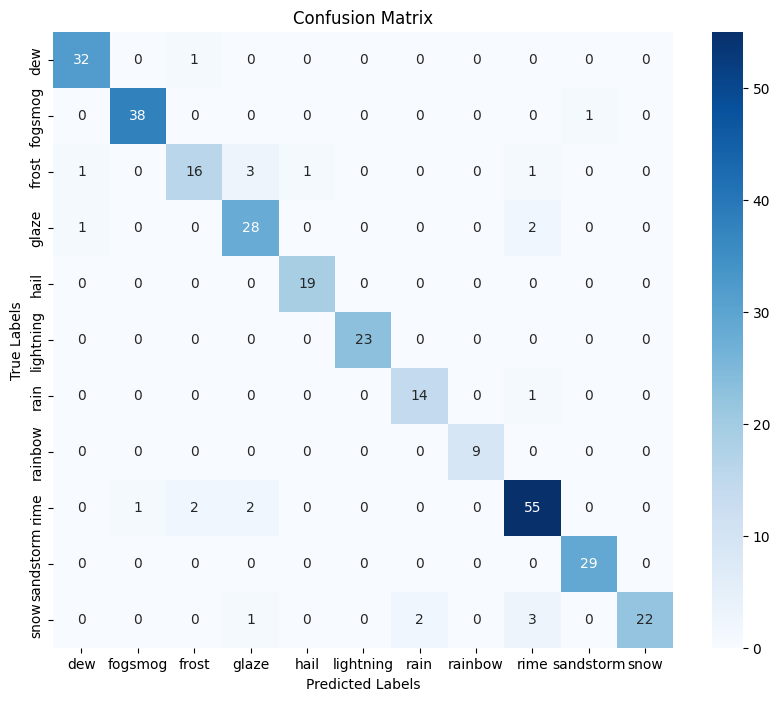

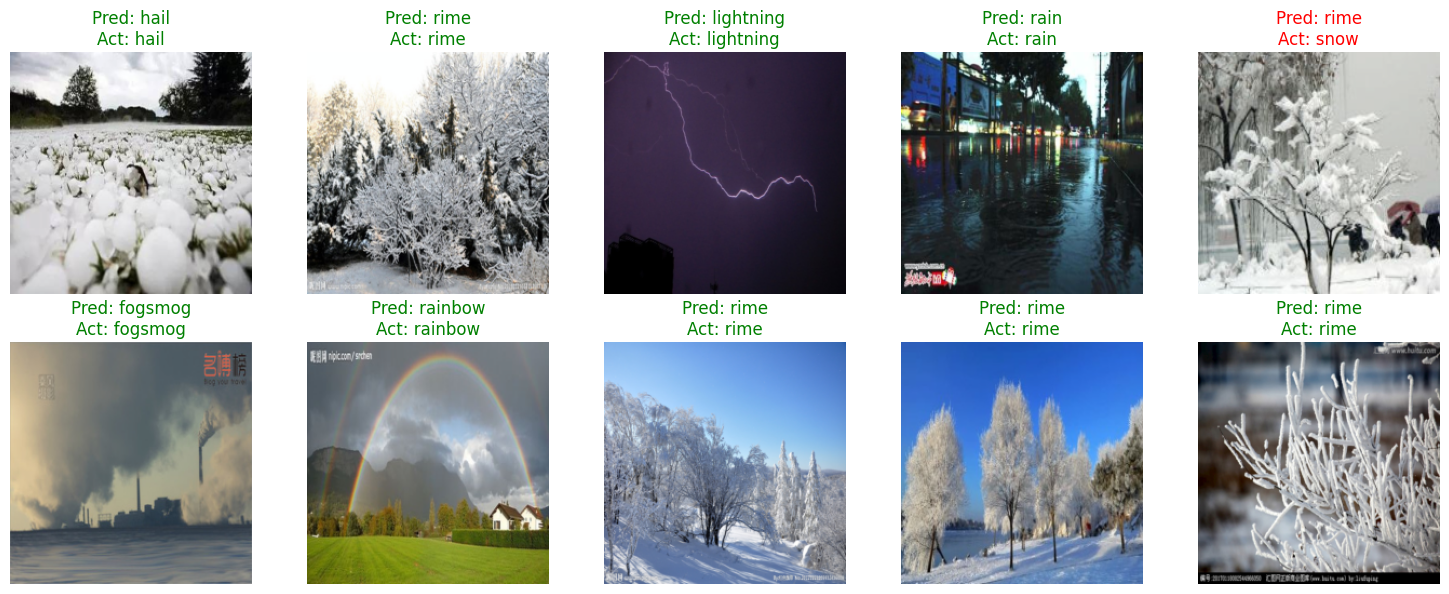

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluation on validation set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions and misclassifications
def visualize_predictions(model, test_loader, num_images=10, dataset_classes=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    images, labels = next(iter(test_loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Display the images
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        image = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        # Determine if prediction is correct
        is_correct = preds[i] == labels[i]
        title_color = 'green' if is_correct else 'red'

        if dataset_classes is not None:
            pred_class = dataset_classes[preds[i]]
            true_class = dataset_classes[labels[i]]
            ax.set_title(f"Pred: {pred_class}\nAct: {true_class}", color=title_color)
        else:
            ax.set_title(f"Pred: {preds[i]}\nAct: {labels[i]}", color=title_color)

        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, val_loader, num_images=10, dataset_classes=dataset.classes)

In [ ]:
# Fine-Tuning and Iteration:
# Function to fine-tune the model
def fine_tune_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device = torch.device("cuda" if torch.cuda.is_available() else "cpu")): # Added device
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved!')

# Example usage
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fine_tune_model(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/5], Train Loss: 0.9151, Val Loss: 1.8709
Model saved!
Epoch [2/5], Train Loss: 0.6732, Val Loss: 1.1407
Model saved!
Epoch [3/5], Train Loss: 0.5323, Val Loss: 1.0819
Model saved!
Epoch [4/5], Train Loss: 0.4527, Val Loss: 1.0866
Epoch [5/5], Train Loss: 0.3903, Val Loss: 0.6847
Model saved!


In [ ]:
# Final Model testing

# Function to test the model on the test dataset
def test_model(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Test the model
test_model(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Test Accuracy: 73.55%


Accuracy: 0.7354838709677419

Classification Report:
               precision    recall  f1-score   support

         dew       0.88      0.85      0.87        27
     fogsmog       0.88      0.78      0.83        37
       frost       0.67      0.64      0.65        25
       glaze       0.64      0.39      0.48        36
        hail       0.91      0.70      0.79        30
   lightning       1.00      1.00      1.00        19
        rain       1.00      0.68      0.81        22
     rainbow       1.00      0.88      0.93         8
        rime       0.79      0.69      0.74        45
   sandstorm       0.77      0.84      0.81        32
        snow       0.39      0.90      0.54        29

    accuracy                           0.74       310
   macro avg       0.81      0.76      0.77       310
weighted avg       0.79      0.74      0.74       310


Confusion Matrix:
 [[23  0  2  0  1  0  0  0  1  0  0]
 [ 1 29  0  0  0  0  0  0  0  4  3]
 [ 0  0 16  4  0  0  0  0  2  2  1]
 [ 2 

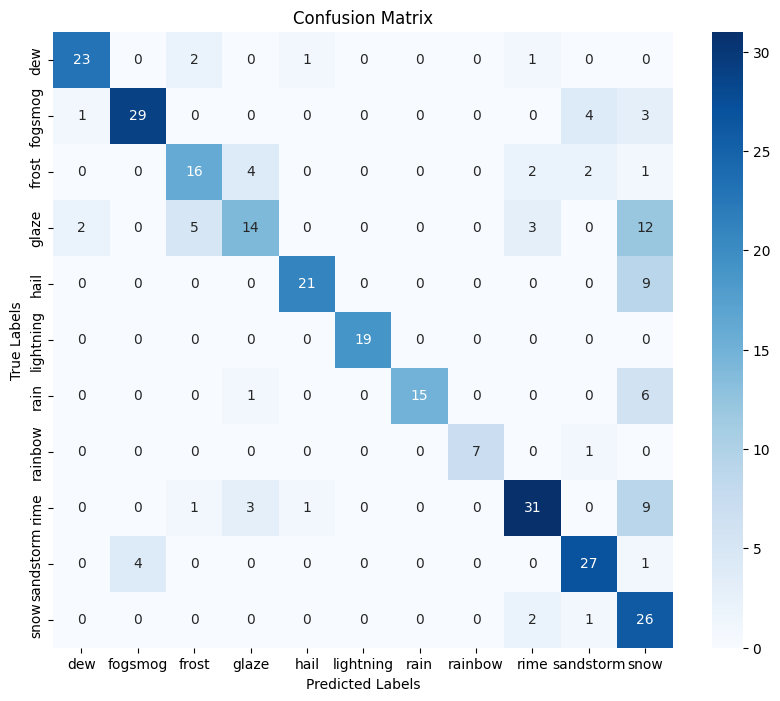

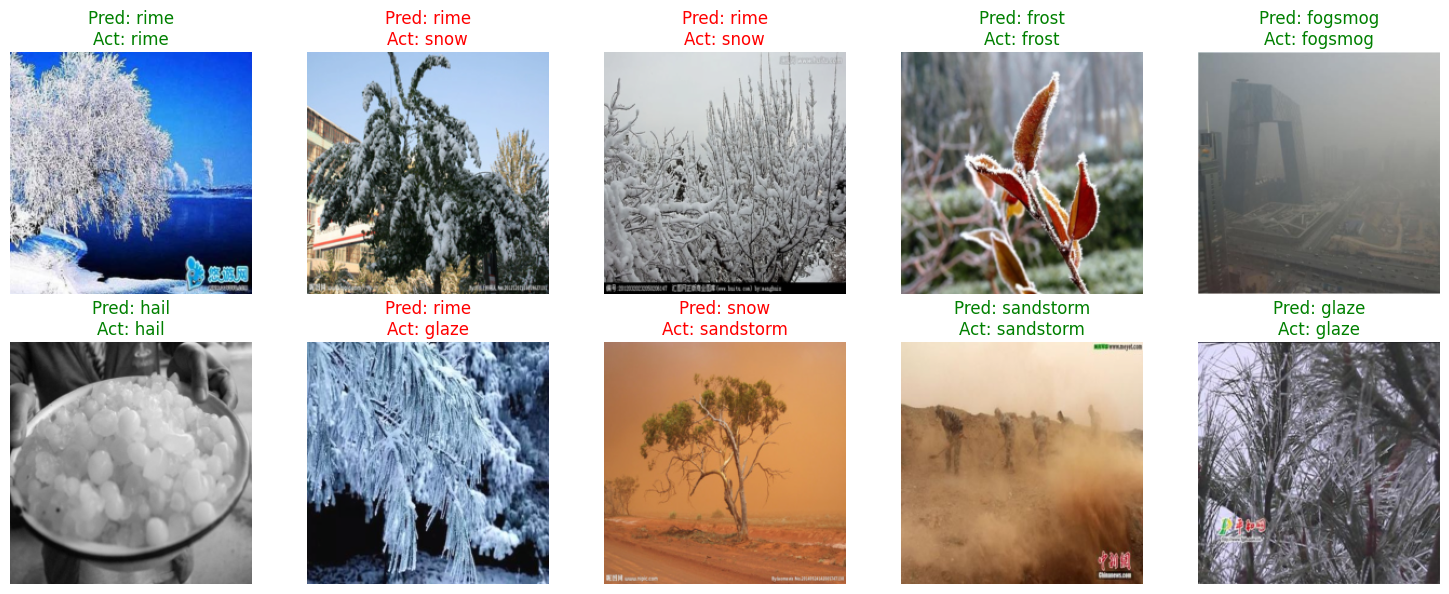

In [ ]:
import matplotlib.pyplot as plt
# Evaluation on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=dataset.classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualize predictions and misclassifications
visualize_predictions(model, test_loader, num_images=10, dataset_classes=dataset.classes)